In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xgcm

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35507/status,
Dashboard: /proxy/35507/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40585,Workers: 4
Dashboard: /proxy/35507/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.124.12:42343,Total threads: 4
Dashboard: /proxy/38347/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43607,


In [4]:
db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_nostress.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_vary_KPP.db'
session_vary_KPP = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_vary_rlds.db'
session_vary_rlds = cc.database.create_session(db)

expt = ['1deg_jra55_ryf_param_KPP', '1deg_jra55_ryf_vary_KPP', '1deg_jra55_ryf_vary_rlds']
session = [session_cont, session_vary_KPP, session_vary_rlds]
name = ['Control', 'Vary_KPP', 'Vary_rlds']

In [5]:
start_time = '1900-01-01'
end_time = '1999-12-31'

start_time_last = '1990-01-01'
end_time_last = end_time

In [6]:
ncoarse = 12

x_min = [-100, -250, -70, -250]
x_max = [ 10 , -100,  20, -80 ]
y_min = [ 20 ,  20 , -80, -80 ]
y_max = [ 75 ,  75 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP']

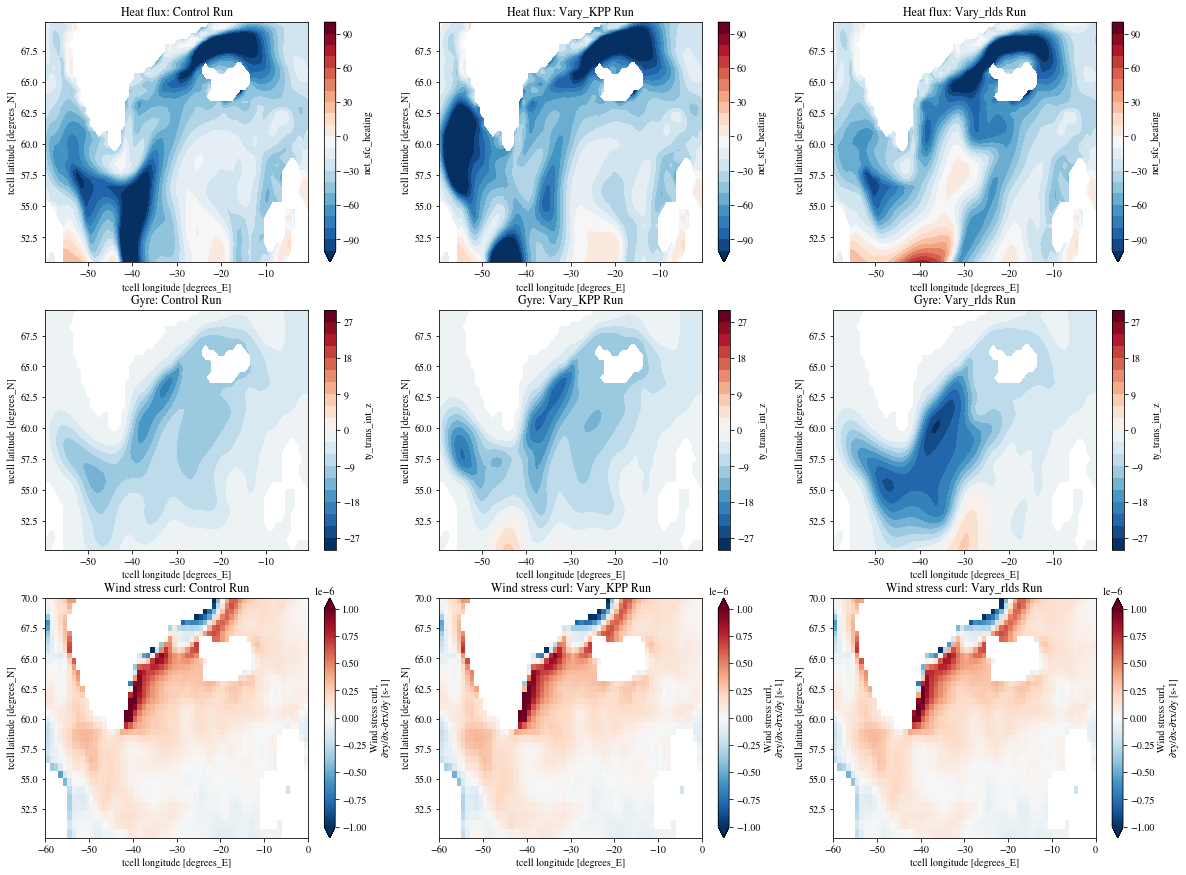

In [9]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 15))

start_time_gyre = '1980-01-01'
end_time_gyre = '1999-12-31'
rho0 = 1025

for i, j in enumerate(session):
    sfc_heat = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly').sel(time = slice(
        start_time_last, end_time_last)).sel(xt_ocean = slice(-60, 0)).sel(yt_ocean = slice(50, 70))
    sfc_heat.mean('time').plot.contourf(ax = axes[0][i], levels = np.linspace(-100, 100, 21))
    axes[0][i].set_title('Heat flux: ' + name[i] + ' Run')
    
for i, j in enumerate(session):
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans_int_z', frequency = '1 monthly').sel(time = slice(
        start_time_gyre, end_time_gyre))
    ty_basin = ty_trans.sel(xt_ocean = slice(-100, 10)).sel(yu_ocean = slice(10, 70))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
    psi_basin.sel(xt_ocean = slice(-60, 0)).sel(yu_ocean = slice(50, 70)).mean('time').plot.contourf(ax = axes[1][i], levels = np.linspace(-30, 30, 21))
    axes[1][i].set_title('Gyre: ' + str(name[i]) + ' Run')

start_time = '1990-01-01'
end_time = '1999-12-31'

dxt = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'dxt', n = -1).rename({'nj':'yt_ocean','ni':'xt_ocean'})
dyt = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'dyt', n = -1).rename({'nj':'yt_ocean','ni':'xt_ocean'})

for i, j in enumerate(session):
    tau_x = cc.querying.getvar(expt = expt[i], session = j, variable = 'tau_x', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    tau_y = cc.querying.getvar(expt = expt[i], session = j, variable = 'tau_y', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    T = cc.querying.getvar(expt = expt[i], session = j, variable = 'temp', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    
    folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
    grid = xr.open_mfdataset(folder + 'ocean_grid.nc', combine = 'by_coords')

    ds = xr.merge([tau_x, tau_y, T, dxt, dyt])
    ds.coords['xt_ocean'].attrs.update(axis='X')
    ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
    ds.coords['yt_ocean'].attrs.update(axis='Y')
    ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

    grid = xgcm.Grid(ds, periodic=['X'])
    
    xτ = grid.interp(grid.diff(ds.tau_y, 'X'), 'Y', boundary='extend')/ds.dxt - grid.interp(grid.diff(ds.tau_x, 'Y', boundary='extend'), 'X')/ds.dyt
    xτ = xτ.rename('Wind stress curl').sel(xt_ocean = slice(-60, 0)).sel(yt_ocean = slice(50, 70)).mean('time')
    xτ.attrs['long_name'] = 'Wind stress curl, ∂τy/∂x-∂τx/∂y'
    xτ.attrs['units'] = 's-1'
    xτ = xτ.drop(['TLON', 'TLAT', 'ULON', 'ULAT'])
    
    xτ.plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r', ax = axes[2][i])
    axes[2][i].set_title('Wind stress curl: ' + str(name[i]) + ' Run')